In [26]:
dataset_id = 7
keyframe_id = 4
frame_id = 1

depth_path = f"./logs/spatialtemporal/models/weights_last/vis_depth/{dataset_id}_{keyframe_id}_{frame_id:06d}.png"
image_path = "/mnt/data/publicData/MICCAI19_SCARED/train/dataset{}/keyframe{}/image_02/data/{:010}.png".format(dataset_id, keyframe_id, frame_id)

import os
import cv2
from matplotlib import pyplot as plt
import numpy as np

def read_img(image_file):
    image = cv2.imread(image_file)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def plot_images(images, cmaps, titles=None):
    num_images = len(images)
    plt.figure(figsize=(5 * num_images, 5))
    
    for idx, img in enumerate(images, start=1):
        plt.subplot(1, num_images, idx)
        if cmaps[idx-1] == 'ori':
            plt.imshow(img)
        else:
            plt.imshow(img, cmap=cmaps[idx-1])
        if titles:
            plt.title(titles[idx-1])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


# 高光检测

### 本项目代码实现

In [20]:
from datasets.specular_detection import SpecularDetection
import torch
detector = SpecularDetection(T1=200, T2_abs=230, T2_rel=2.0, T3=4, N_min=1500)


### 反转代码实现

In [34]:
# def process(img):
#     inverted = 255 - img
#     gray1 = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     gray2 = cv2.cvtColor(inverted, cv2.COLOR_RGB2GRAY)
#     diff = cv2.absdiff(gray1, gray2)
#     print(f'max: {diff.max()}, min: {diff.min()}')
#     threshold = np.percentile(diff, 98)
#     mask = np.where(diff >= threshold, 0, 255).astype(np.uint8)
#     return mask

def process(img):
    gray1 = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 使用IQR方法检测异常亮值
    q75, q25 = np.percentile(gray1, [75, 25])
    iqr = q75 - q25
    
    # 定义异常值阈值（上界）
    upper_bound = q75 + 1.5 * iqr
    
    print(f'Q1: {q25}, Q3: {q75}, IQR: {iqr}, 上界: {upper_bound}')
    
    # 创建mask：亮部为0（黑色），其他为255（白色）
    mask = np.where(gray1 >= upper_bound, 0, 255).astype(np.uint8)
    return mask


### 比较

Q1: 52.0, Q3: 132.0, IQR: 80.0, 上界: 252.0


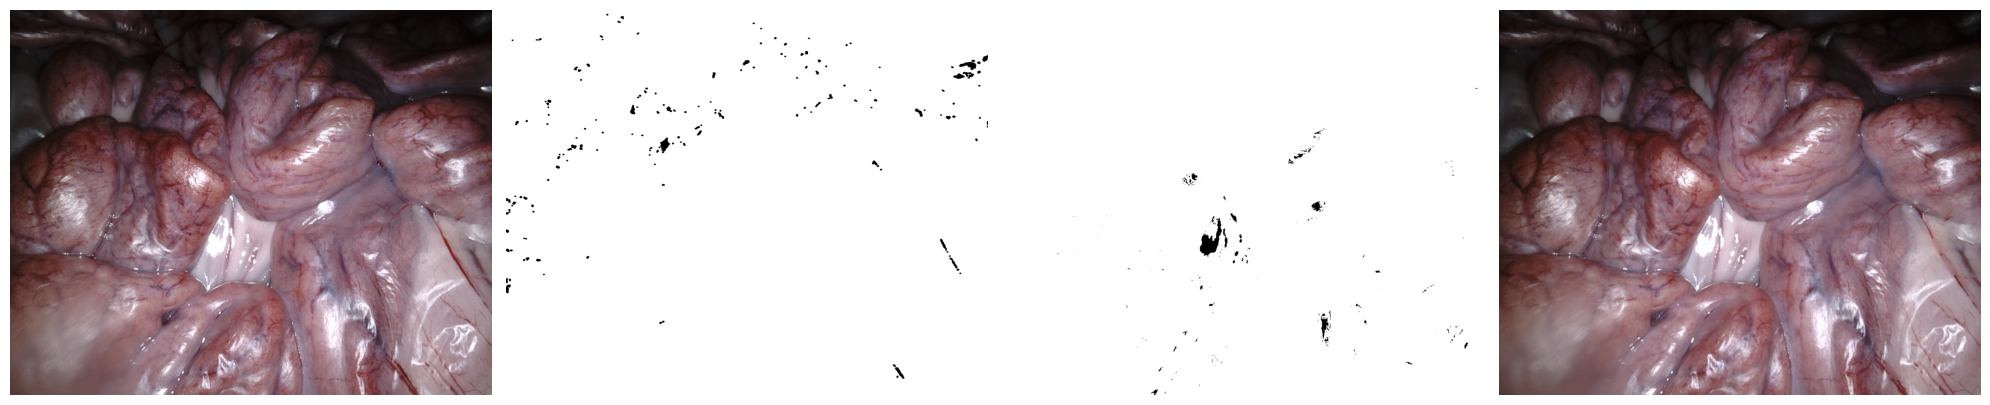

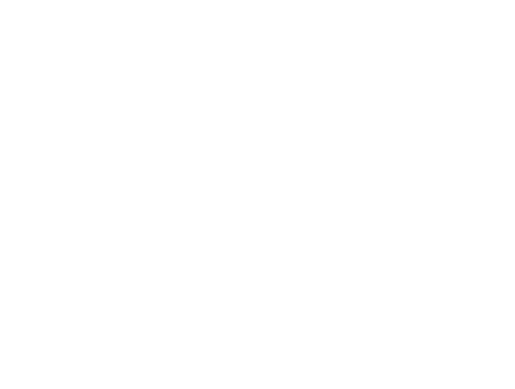

In [49]:
# 本项目mask
image = read_img(image_path)
result = detector(image)
mask = result["point"]  # 高光掩码
clean_image = result["inpaint"]  # 去除后的图像
if mask.dim() == 3 and mask.shape[0] == 1:
    mask = mask.squeeze(0)
mask = 1-mask
# 转换为 numpy 数组
mask_np = mask.numpy()
clean_image = clean_image.numpy()
clean_image_display = np.transpose(clean_image, (1, 2, 0))
clean_image_display = 1 - clean_image_display
# 反转绘制
mask_rev = process(image)

# 使用 matplotlib 绘制
plot_images([image, mask_np, mask_rev, clean_image_display], ['ori','gray', 'gray', 'ori'])
plt.axis('off')  # 关闭坐标轴
plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


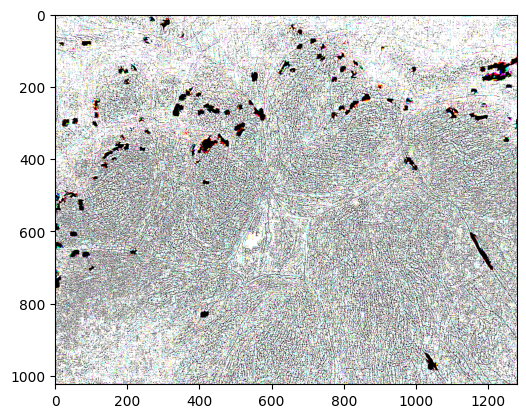

In [51]:
plt.imshow(image - 255*(clean_image_display))

### 更改检测机制

In [54]:
from typing import Any
import numpy as np
import cv2
import torch

def dilateByELLIPSE(img, radius):
    disk_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * radius + 1, 2 * radius + 1))
    return cv2.dilate(img, disk_kernel)

"""Reference: https://github.com/Be997398715/matalb-remove-specular-highlights-
"""
class SpecularDetection2:
    def __init__(self, T1=200, T2_abs=230, T2_rel=2.0, T3=4, N_min=1500, decay_win_size=10, decay_cof=20) -> None:
        # 保留原有参数以保持兼容性
        self.T1 = T1
        self.T2_abs = T2_abs
        self.T2_rel = T2_rel
        self.T3 = T3
        self.N_min = N_min
        
        # 新增参数用于异常亮值检测
        self.bright_threshold = 2.0  # Z-score阈值
        
        # 修复相关参数
        self.decay_win_size = decay_win_size
        self.decay_cof = decay_cof

    def __call__(self, *args: Any, **kwds: Any) -> Any:
        return self.detection(*args, **kwds)

    def detection(self, img):
        if torch.is_tensor(img):
            img = img.permute(1, 2, 0).squeeze().numpy()

        if img.max() <= 1.0 + 1e-3:
            img = (img * 255).astype(np.uint8)

        # 使用图像和反转图像检测异常亮值
        mask = self.generate_mask_by_inverted_method(img)
        
        # 使用原有的分类和修复方法
        mask_highlight = self.classify(mask, self.N_min)
        inpaint_img = self.inpaintting(mask_highlight, img)
        
        # 转换为输出格式
        inpaint_img = torch.from_numpy(inpaint_img/255.0).permute(2, 0, 1)
        mask_highlight = np.expand_dims(mask_highlight, axis=0)
        
        return {
            "point": torch.from_numpy(mask_highlight),
            "inpaint": inpaint_img,
        }

    def generate_mask_by_inverted_method(self, img):
        """使用图像和反转图像检测异常亮值"""
        # 创建反转图像
        inverted = 255 - img
        
        # 转换为灰度图
        gray1 = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(np.float32)
        gray2 = cv2.cvtColor(inverted, cv2.COLOR_RGB2GRAY).astype(np.float32)
        
        # 使用IQR方法在gray1中检测异常亮值
        q75, q25 = np.percentile(gray1, [75, 25])
        iqr = q75 - q25
        
        # 定义异常亮值阈值（上界）
        upper_bound = q75 + 1.5 * iqr
        
        # 创建高光mask
        mask = (gray1 >= upper_bound).astype(np.uint8) * 255
        
        # 膨胀操作使mask更完整
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        mask = cv2.dilate(mask, kernel, iterations=1)
        
        return mask

    def fillImage(self, mask: np.ndarray, img: np.ndarray):
        """保留原有的fillImage方法"""
        img2 = np.copy(img)
        
        dilated_mask_1 = dilateByELLIPSE(mask, 2)
        dilated_mask_2 = dilateByELLIPSE(mask, 4)
        dilated_area = dilated_mask_2 - dilated_mask_1

        nums1, labels1, _, centroids1 = cv2.connectedComponentsWithStats(dilated_area)
        nums2, labels2, _, centroids2 = cv2.connectedComponentsWithStats(mask)
        mean_color = []

        for label in range(1, nums1):
            mean_color.append(np.median(img2[labels1==label], axis=0))
        
        for label in range(1, nums2):
            centroids = centroids2[label]
            nearest_idx = 1
            nearest_dist = np.linalg.norm(centroids - centroids1[nearest_idx])
            for idx in range(2, nums1):
                dist = np.linalg.norm(centroids - centroids1[idx])
                if dist < nearest_dist:
                    nearest_dist = dist
                    nearest_idx = idx

            img2[labels2==label] = mean_color[nearest_idx-1]

        return img2

    def inpaintting(self, specular_mask, img):
        """保留原有的inpaintting方法"""
        filled_img = self.fillImage(specular_mask.astype(np.uint8)*255, img)
        sig = 8
        gaussian_filtered_img = cv2.GaussianBlur(filled_img, (0, 0), sig)
        
        filter_kernel = np.ones((self.decay_win_size, self.decay_win_size)) / self.decay_cof
        mx = cv2.filter2D(specular_mask, -1, filter_kernel)
        mx = mx + specular_mask
        mx[mx > 1] = 1.0
        
        mx = np.stack([mx] * 3, axis=2)

        inpainted_img = mx * gaussian_filtered_img + (1 - mx) * img
        inpainted_img = cv2.medianBlur(inpainted_img.astype(np.uint8), 3).astype(float)

        return inpainted_img
    
    def classify(self, mask, N_min):
        """保留原有的classify方法"""
        nums, labels = cv2.connectedComponents(mask)
        mask_highlight = np.zeros_like(mask).astype(np.float32)

        for label in range(1, nums):
            N = np.sum(labels == label)
            if N < N_min:
                mask_highlight[labels == label] = 1.0

        return mask_highlight

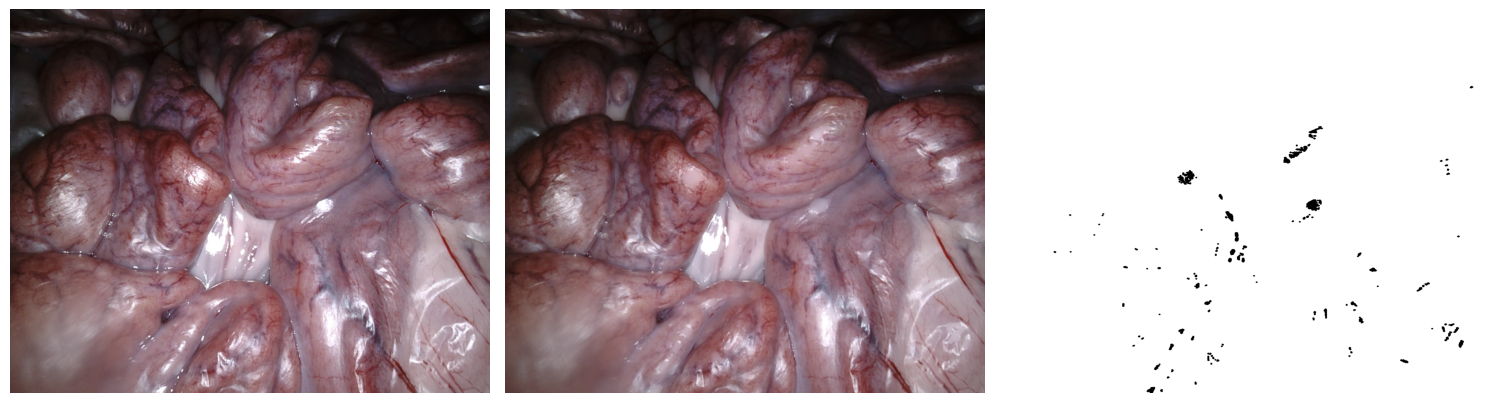

In [58]:
detector2 = SpecularDetection2()
res = detector2(image)
mask = res["point"]  # 高光掩码
clean_image = res["inpaint"]  # 去除后的图像
if mask.dim() == 3 and mask.shape[0] == 1:
    mask = mask.squeeze(0)
mask = 1-mask
# 转换为 numpy 数组
mask_np = mask.numpy()
clean_image = clean_image.numpy()
clean_image_display = np.transpose(clean_image, (1, 2, 0))
plot_images([image, clean_image_display, mask], ["ori", "ori", "gray"])